### IMAGE RECOGNITION BY TRANSFER LEARNING

**Highlights:**
 <br> 1. VGG-16 Transfer learning methodology is utilised. It basically a CNN architecture with 16 layers [all with tuneable parameters; 13 convolutional layers plus 3 fully connected layers; excluding the non-tuneable max-pool layers]
 <br> 2. All of the images concerns the hand gesture of digits from 0 to 9 
 <br> 3. Data Augmentation tehcnique as not many images are available for training
 <br> 4. Early stopping and dropout to avoid model overfitting 

Import all the necessary library packages

In [77]:
import glob,random,cv2
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.layers import Dropout, Flatten, GlobalMaxPooling2D, Dense

import os

#### About the dataset

<br> -> train: 185 unique images for each digit
<br> -> test: 20 unique images for each digit
<br> -> validate: 1 unique image for each digit

In [29]:
train_data = glob.glob('../3. Image Recognition Using Transfer Learning/train/**/*.jpg')
test_data = glob.glob('../3. Image Recognition Using Transfer Learning/test/**/*.jpg')
val_data = glob.glob('../3. Image Recognition Using Transfer Learning/validate/**.jpg')
random.shuffle(train_data)
random.shuffle(test_data)
print(f"Training Set has: {len(train_data)} images")
print(f"Testing Set has: {len(test_data)} images")
print(f"Validation Set has: {len(val_data)} images")

Training Set has: 1852 images
Testing Set has: 200 images
Validation Set has: 10 images


To give the reader an idea about the hand gesture for each individual digit I'm utilising the validate dataset folder which has all of these 10 images

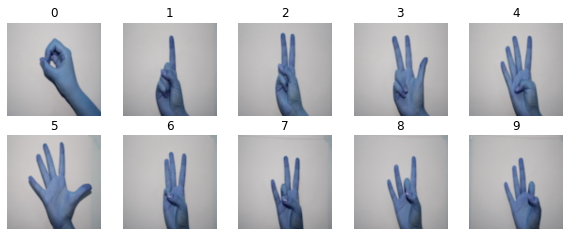

In [30]:
fig=plt.figure(figsize=(10, 10))
length = width = len(val_data)//2
for i in range(len(val_data)):
    img = cv2.imread(val_data[i])
    img = cv2.resize(img, (224, 224))
    fig.add_subplot(length,width,i+1,title=i)
    plt.imshow(img)
    plt.axis(False)

#### Exploratory Data Analysis

One (more than 60 in practise- erosion, edge detection, dilation, fourier-transform, augmentation, etc to name a few) of the most important image analysis implementation that I used in reliaty before actually choosing the CNN architecture. Because the similar behavior with VGG16 feature maps were realised, I choose this particular architecture. Understand that during the project execution (similar task but not hand gesture rather the physical objects) most of the research work (about 45%) was allocated to this particular section.

Here again using the validate data (for the purpose to show how the featuremap varies with each digit respectively)

<u> Background Subtraction

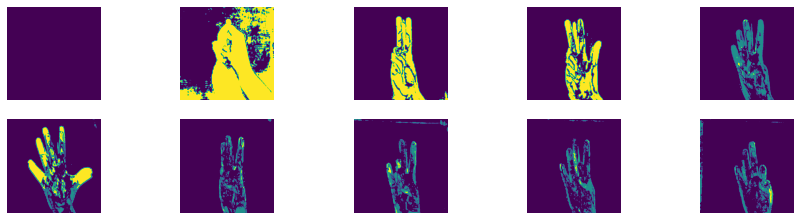

In [31]:
fgbg = cv2.createBackgroundSubtractorMOG2()

fig=plt.figure(figsize=(15, 10))
columns = 5; rows = 5
for i in range(len(val_data)):
    img = cv2.imread(val_data[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = fgbg.apply(img)
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
    plt.axis(False)

#### Model Building

<u> Data Augmentation- Train and Test Data

In [32]:
train_gen = ImageDataGenerator(
    rescale=1/255.,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=0.4,
    zoom_range=0.4
)

In [33]:
# target_size match the VGG-16 input size
Train = train_gen.flow_from_directory(
    "../3. Image Recognition Using Transfer Learning/train/",
    target_size=(224, 224),
    batch_size=16
)
Test = train_gen.flow_from_directory(
    "../3. Image Recognition Using Transfer Learning/test",
    target_size=(224, 224),
    batch_size=8
)

Found 1852 images belonging to 10 classes.
Found 200 images belonging to 10 classes.


<u> Using the Existing Architecture

In [39]:
cnn_arch = tf.keras.applications.VGG16(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

VGG-16 is already trained with huge data so we can use those layers and need not modify any. Except the last layer where we would be retraining with the target classes (10 in number)

In [44]:
for layer in cnn_arch.layers:
        print(layer.name)
        layer.trainable = False

input_3
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [49]:
cnn_arch_finallayer = cnn_arch.get_layer('block5_pool')
cnn_arch_output = cnn_arch_finallayer.output
output = GlobalMaxPooling2D()(cnn_arch_output)
output = Flatten()(x)
output = Dense(512, activation='relu')(x)
output = Dropout(0.5)(x)
output = Dense(10, activation='sigmoid')(x)

<u> Model

Notice that the epochs must be in the range from 50-60 for a very fine prediction accuracy. For the instantiation the epochs of 5 is used (as training takes a lot of time) and therefore not extreme expected accuracy

In [53]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=6)
model = tf.keras.Model(cnn_arch.input, output)
model.compile(optimizer='adam', loss=tf.keras.losses.categorical_crossentropy, metrics=['acc'])
VGG_classifier = model.fit(Train,
epochs = 5,
validation_data=Test,
batch_size = 16,
callbacks=[callback],                           
verbose = 1)

Epoch 1/5
116/116 [==============================] - 791s 7s/step - loss: 2.2192 - acc: 0.1874 - val_loss: 2.1418 - val_acc: 0.2700
Epoch 2/5
116/116 [==============================] - 706s 6s/step - loss: 1.9286 - acc: 0.3952 - val_loss: 2.0171 - val_acc: 0.3100
Epoch 3/5
116/116 [==============================] - 665s 6s/step - loss: 1.7292 - acc: 0.5043 - val_loss: 1.9048 - val_acc: 0.3900
Epoch 4/5
116/116 [==============================] - 712s 6s/step - loss: 1.5707 - acc: 0.5702 - val_loss: 1.7461 - val_acc: 0.4600
Epoch 5/5
116/116 [==============================] - 751s 6s/step - loss: 1.4412 - acc: 0.6479 - val_loss: 1.6985 - val_acc: 0.4450


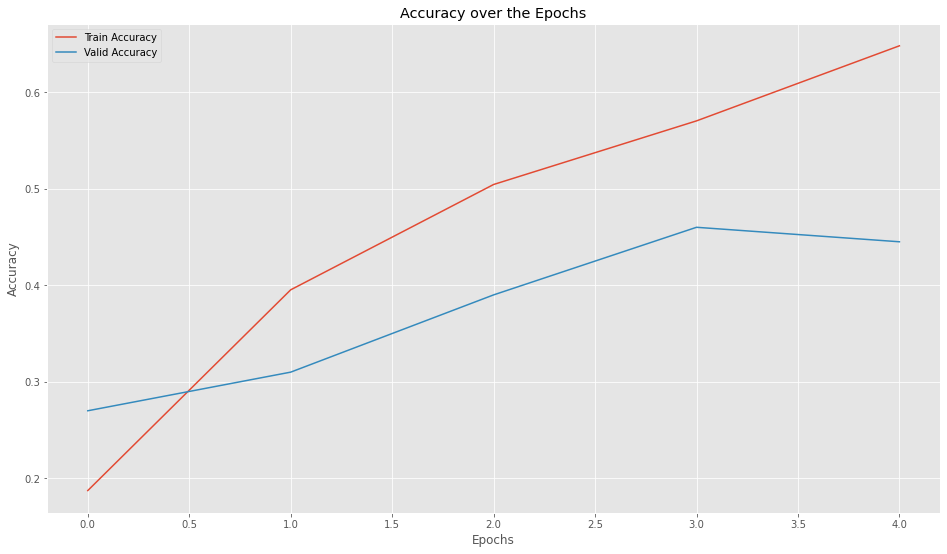

In [56]:
plt.style.use("ggplot")
plt.figure(figsize=(16, 9))
plt.plot(VGG_classifier.history['acc'], label="Train Accuracy")
plt.plot(VGG_classifier.history['val_acc'], label="Valid Accuracy")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy over the Epochs")
plt.show()

<u> Prediction

Prediction with a single image (randomly selected) from validation dataset

1/1 [==============================] - 0s 316ms/step
Predicted Class: 1 
Image name in validate folder: Img_1119.Jpg 
Class probability: 0.90128654


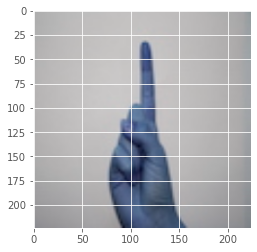

In [81]:
pred_dir_path = '../3. Image Recognition Using Transfer Learning/validate'
class_names = sorted(os.listdir(pred_dir_path))

n = random.randrange(10) # random number between 0-9

img = load_img(val_data[n], target_size=(224,224))
img_array = img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

Detection = model.predict(img_array)
score = Detection[0]

print("Predicted Class:", np.argmax(score), "\nImage name in validate folder:", class_names[np.argmax(score)].title(), "\nClass probability:", np.max(score))

# Display image
img = cv2.imread(val_data[n])
img = cv2.resize(img, (224, 224))
plt.imshow(img)

### THE END